# 1. Confined Aquifer Test - Oude Korendijk
**This example is taken from Kruseman and de Ridder (1970)**

## Introduction and Conceptual Model

In this example we will analyse the pumping test data from Oude Korendijk (Kruseman and de Ridder, 1970). This is a polder area south of Rotterdam, the Netherlands. The stratigraphy can be summarised by:
* the presence in the first 18 m depth of a impermeable layer,
* followed by a 7 m succession of coarse gravel and sands, which are considered as the aquifer layer,
* and finally a layer of fine sands and clayey sediments that are deemed impermeable.

The well screen was placed at the whole thickness of the aquifer. Drawdowns were taken from piezometers installed 30 and 90 m away from the well. Pumping at the well has been taken with constant discharge of 788 m3/d for almost 14 hours.

The conceptual model of the area is a single layer confined aquifer located at 18 m below surface and 7 m thickness. At $t=0$ pumping starts at constant discharge of 788 m3/d and drawdowns are recorded at two piezometers, 30 and 90 meters away, respectively. The figure below summarises the conceptualization of the problem

![Conceptual Model](figures/nb_01_conc_model.png)

## Step 1: Loading libraries

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from ttim import *
import pandas as pd

## Step 2: Setting basic parameters for the model

In [36]:
H = 7 #aquifer thickness in meters
zt = -18 #top boundary of aquifer (m)
zb = zt - H #bottom boundary of aquifer (m)
Q = 788 #constant discharge m3/d

<a id='step_3'></a>
## Step 3: Creating a TTim conceptual model

In this example, we are using the ModelMaq model to conceptualize our aquifer. ModelMaq defines the aquifer system as a stacked vertical sequence of aquifers and leaky layers (aquifer-leaky layer, aquifer-leaky layer, etc). Aquifers are conceptualized as having no vertical resistance (Dupuit approximation), with constant hydraulic conductivity and storage. Aquitard layers are approximated as having only vertical flow. They are characterized by the parameter resistance to vertical flow and by having no storage.

In the model construction, we have to set the parameters for each layer (which consists of an aquifer layer and an aquitard layer).

For our one layer model we have to set:

- The hydraulic conductivity: ```kaq``` (We will first assume a value of 60 m/d, but will later calibrate it with the pumping data). This can be a float or a list/array, depending on the number of layers, see notebook (***multi-aquifer notebook reference***).
- The top and bottom of the aquifer: ```z``` defined by a list ```[zt,zb]```. This construction is slightly different in multi-aquifer configurations, as can be seen in notebook (***multi-aquifer notebook reference***).
- The specific storage: ```Saq```, a float or list/array which will also be calibrated later. Again, defined for each aquifer layer.
- The minimum time for which TTim solve the groundwater flow: ```tmin```, a float.
- And the maximum time: ```tmax```, float.

In case of more than one layer model we would also have to set the resistance to vertical flow ```c``` of the aquitard portions. An example of this configuration can be seen in the notebook (***Insert the reference to multi-layer benchmark***)

To represent our pumping well, we will use the ```Well``` feature.
For the well we have to set:
- The TTim model: ```ml``` where it is placed
- The x and y location: ```xw, yw```, floats
- The pumping scheme defined by a list (```tsandQ```) where each element is a tuple representing a new stress condition with the starting time and the discharge rate, in our case: ```(0,Q)``` meaning that pumping begins at t = 0 with pumping rate Q
- The layers where it is screened: ```layers```, which can be set as an integer (one layer) or a list of integers (multi-screen well).

In [37]:
#unkonwn parameters: kaq, Saq
ml = ModelMaq(kaq=60, z=[zt, zb], Saq=1e-4, tmin=1e-5, tmax=1)
w = Well(ml, xw=0, yw=0, rw=0.2, tsandQ=[(0, Q)], layers=0)

# Here we are setting everything in meters for length and days for time

The last step in our model creation is to "solve" the model:

In [38]:
ml.solve(silent='True')

## Step 4: Load data of two observation wells:

The preferred method of loading data into TTim is to use numpy arrays.

The data is in a text file where the first column is the time data in ***minutes*** and the second column is the drawdown in ***meters***

For each piezometer we will load the data as a numpy array and create separate time from drawdown into two different 1d arrays. Time data will also be converted from minutes to days

In [39]:
#time and drawdown of piezometer 30m away from pumping well
data1 = np.loadtxt('data/piezometer_h30.txt', skiprows = 1)
t1 = data1[:, 0] / 60 / 24 #convert min to days
h1 = data1[:, 1]
r1 = 30
#time and drawdown of piezometer 90m away from pumping well
data2 = np.loadtxt('data/piezometer_h90.txt', skiprows = 1)
t2 = data2[:, 0] / 60 / 24 #convert min to days
h2 = data2[:, 1]
r2 = 90

## Step 5: Calibration

For the calibration of our groundwater model we proceed by creating a calibration object with the ```Calibrate``` class. The ```Calibrate``` object takes the model ```ml``` as argument.
We then set the parameters we are adjusting:
- Hydraulic conductivity: ```kaq0``` (Hydraulic conductivity of layer 0)
- Specific Storage ```Saq0``` (Specific Storage of layer 0)

with the ```.set_parameter``` method.

- ```.set_parameter``` takes two arguments:
- ```name``` is the parameter name, a string, where the letters define the parameter. The possible values are "kaq", "Saq" or 'c', and they represent hydraulic conductivity, Specific storage and resistance to vertical flow, respectively. The letters are followed by a number, that define the layer of that parameter. For the example ```"kaq0"``` means the hydraulic conductivity of the layer 0.
    - ```initial```is the initial guess value for the fitting algorithmn.

We can also add the optional parameters:
- ```pmin``` and ```pmax```, which are floats that define the minimum and maximum possible values for the parameter.

We add the observation data using the ```.series``` method. The arguments are:
 - ```name```: string with the observation name
 - ```x``` and ```y```: float positions of the observation
 - ```t```: the array of observation times
 - ```h```: the array of observed drawdowns
 - ```layer```: integer. The layer of the observation (0 indexed)


<a id='step_5_1'></a>
### Step 5.1: Calibration with Observation from Piezometer 1 (30 m from well)

We begin calibrating using only the data from observation 1:

In [40]:
ca1 = Calibrate(ml) # Calibrate object
ca1.set_parameter(name = 'kaq0', initial=10) # Setting parameters
ca1.set_parameter(name = 'Saq0', initial=1e-4)
ca1.series(name = 'obs1', x=r1, y=0, t=t1, h=h1, layer=0) # Adding observations


The ```fit``` method is used to run the least-squares algorithmn for finding the optimal parameter values:

In [41]:
ca1.fit(report = True) # Fitting the model. We can hide the message below setting report = False

.........................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 34
    # variables        = 2
    chi-square         = 0.03408049
    reduced chi-square = 0.00106502
    Akaike info crit   = -230.783289
    Bayesian info crit = -227.730568
[[Variables]]
    kaq0:  68.6394868 +/- 1.43827068 (2.10%) (init = 10)
    Saq0:  1.6072e-05 +/- 1.5823e-06 (9.85%) (init = 0.0001)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq0, Saq0) = -0.891


The optimal parameters and their related fit statistics are saved inside the ```Calibrate``` object as a DataFrame in the ```.parameters``` attribute:

In [42]:
ca1.parameters

,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0,68.6395,1.438271,2.0954,-inf,inf,10,[68.63948675671419]
Saq0,1.60717e-05,0.000002,9.84519,-inf,inf,0.0001,[1.6071655613732773e-05]


The calibration RMSE can be accessed with the ```.rmse``` method:

In [43]:
print('rmse:', ca1.rmse())

rmse: 0.031660183647463674


Finally, we can access the model drawdowns by asking for the calibrated model to compute the heads at the well location and time intervals specified by the sampled data.

For this we use the ```.head``` method in the model object, in our case, ```ml```.

The arguments are:
* the positions ```x``` and ```y``` of the piezometric well (or any other point of interest). In our case, our well is located at position ```x= r1``` and ```y = 0```.
* the time intervals, defined by the numpy array ```t```, for the computation of the heads. In our case, this is defined by the variable ```t1```.

* Another optional inputs is ```layers```, that can be a list, integer or an array defining the model layers that shall be computed. For our case, we will not define anything, and TTim will compute for all layers (just one layer model).

The output is a numpy array with dimensions ```(nl,nt)```, where ```nl``` is the number of layers and ```nt``` is the number of time intervals

In [44]:
hm1 = ml.head(x = r1, y = 0, t = t1) #Using the head method to calculate model resuts
hm1.shape #Demonstration of the output shape

(1, 34)

### Plotting the model Results

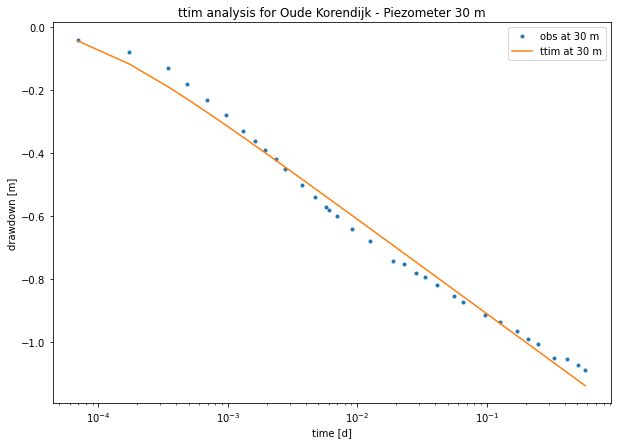

In [45]:
#matplotlib plot for calibration, 
plt.figure(figsize=(10, 7))
plt.semilogx(t1, h1, '.', label='obs at 30 m') #Plotting the observed drawdown
plt.semilogx(t1, hm1[0], label='ttim at 30 m') #Simulated drawdown
plt.xlabel('time [d]')
plt.ylabel('drawdown [m]')
plt.title('ttim analysis for Oude Korendijk - Piezometer 30 m')
plt.legend();

## Step 5.2. Calibrate model Parameters with Observation Well 2 (90 m distance)

 We proceed to calibrate using only the data from observation well 2.
 This time we will rush foward through the calibration steps. If the user feels confused, one can go back and check the inputs in [***step 5.1***](#step_5_1)

In [46]:
ca2 = Calibrate(ml)
ca2.set_parameter(name='kaq0', initial=10)
ca2.set_parameter(name='Saq0', initial=1e-4)
ca2.series(name='obs2', x=r2, y=0, t=t2, h=h2, layer=0)
ca2.fit(report=True)
ca2.parameters

...............................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 35
    # variables        = 2
    chi-square         = 0.01806492
    reduced chi-square = 5.4742e-04
    Akaike info crit   = -260.919608
    Bayesian info crit = -257.808912
[[Variables]]
    kaq0:  71.5831423 +/- 1.57402551 (2.20%) (init = 10)
    Saq0:  2.9106e-05 +/- 1.9379e-06 (6.66%) (init = 0.0001)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq0, Saq0) = -0.847


,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0,71.5831,1.574026,2.19888,-inf,inf,10,[71.58314231775141]
Saq0,2.91065e-05,0.000002,6.65787,-inf,inf,0.0001,[2.910648177493867e-05]


rmse: 0.022718724430908815


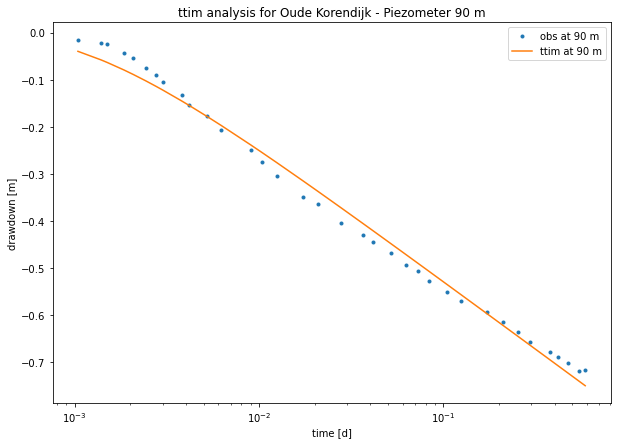

In [47]:
print('rmse:', ca2.rmse())
hm2 = ml.head(r2, 0, t2)
plt.figure(figsize=(10, 7))
plt.semilogx(t2, h2, '.', label='obs at 90 m')
plt.semilogx(t2, hm2[0], label='ttim at 90 m')
plt.xlabel('time [d]')
plt.ylabel('drawdown [m]')
plt.title('ttim analysis for Oude Korendijk - Piezometer 90 m')
plt.legend();

## Step 5.3. Calibrate model with two datasets simultaneously

Here we explore the hability of TTim to calibrate the model using more than one observation location.

This can be done simply by calling the method ```.series``` multiple times to the ```Calibrate``` object:

In [48]:
ca = Calibrate(ml)
ca.set_parameter(name='kaq0', initial=10)
ca.set_parameter(name='Saq0', initial=1e-4)
ca.series(name='obs1', x=r1, y=0, t=t1, h=h1, layer=0) # Adding well 1
ca.series(name='obs2', x=r2, y=0, t=t2, h=h2, layer=0) # Adding well 2
ca.fit(report=True)
ca.parameters

..................................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 69
    # variables        = 2
    chi-square         = 0.17291362
    reduced chi-square = 0.00258080
    Akaike info crit   = -409.245802
    Bayesian info crit = -404.777589
[[Variables]]
    kaq0:  66.0893566 +/- 1.65498708 (2.50%) (init = 10)
    Saq0:  2.5409e-05 +/- 2.4016e-06 (9.45%) (init = 0.0001)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq0, Saq0) = -0.855


,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0,66.0894,1.654987,2.50417,-inf,inf,10,[66.0893566210241]
Saq0,2.54086e-05,0.000002,9.45189,-inf,inf,0.0001,[2.5408624326744147e-05]


rmse: 0.050059909702252964


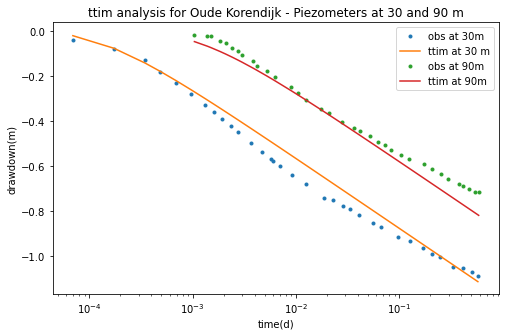

In [49]:
print('rmse:', ca.rmse())
hs1 = ml.head(r1, 0, t1)
hs2 = ml.head(r2, 0 ,t2)
plt.figure(figsize = (8, 5))
plt.semilogx(t1, h1, '.', label='obs at 30m')
plt.semilogx(t1, hs1[0], label='ttim at 30 m')
plt.semilogx(t2, h2, '.', label='obs at 90m')
plt.semilogx(t2, hs2[0], label = 'ttim at 90m')
plt.xlabel('time(d)')
plt.ylabel('drawdown(m)')
plt.title('ttim analysis for Oude Korendijk - Piezometers at 30 and 90 m')
plt.legend();

## Step 6. Calibrate Model with Wellbore Storage

In this continuation, we investigate whether adding well bore storage improves the fit.

### Step 6.1. Reload the model

In [65]:
#unknown parameters: kaq, Saq and rc
ml1 = ModelMaq(kaq=60, z=[zt, zb], Saq=1e-4, tmin=1e-5, tmax=1)

### Step 6.2. Define new Well object with wellbore storage

Now, besides the parameters explained in [Step 3](#step_3), we have to add the radius of the caisson (```rc```)

In [66]:
w1 = Well(ml1, xw=0, yw=0, rw=0.2, rc=0.3, tsandQ=[(0, Q)], layers=0)
ml1.solve(silent='True')

### Step 6.3. Calibrate using only the data from observation well 1

Here we use the method ```.set_parameter_by_reference``` to calibrate the rc parameter in our well.

```.set_parameter_by_reference``` takes the following arguments:
* ```name```: string of the parameter name
* ```parameter```: numpy-array with the parameter to be optimized. It should be specified as a reference, for example, in our case: ```w1.rc[0:]``` referencing to the parameter ```rc``` in object ```w1```.
* ```initial```: float with the initial guess for the parameter value.
* ```pmin```and ```pmax```: floats with the minimum and maximum values allowed for the parameter to be optimized. If not specified these will be defined as ```-np.inf``` and ```np.inf```.

In [67]:
ca3 = Calibrate(ml1)
ca3.set_parameter(name='kaq0', initial=10)
ca3.set_parameter(name='Saq0', initial=1e-4)
#ca3.set_parameter_by_reference(name='rc', parameter=w1.rc[0:], initial=0.2, pmin=0.01)
ca3.series(name='obs1', x=r1, y=0, t=t1, h=h1, layer=0)
ca3.fit(report=True)
ca3.parameters

................................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 34
    # variables        = 2
    chi-square         = 0.00794623
    reduced chi-square = 2.4832e-04
    Akaike info crit   = -280.288200
    Bayesian info crit = -277.235479
[[Variables]]
    kaq0:  80.6405644 +/- 0.93948623 (1.17%) (init = 10)
    Saq0:  5.5994e-06 +/- 3.8942e-07 (6.95%) (init = 0.0001)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq0, Saq0) = -0.921


,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0,80.6406,9.394862e-01,1.16503,-inf,inf,10,[80.64056435863938]
Saq0,5.5994e-06,3.894218e-07,6.9547,-inf,inf,0.0001,[5.599401724943624e-06]


rmse: 0.015287667397425852


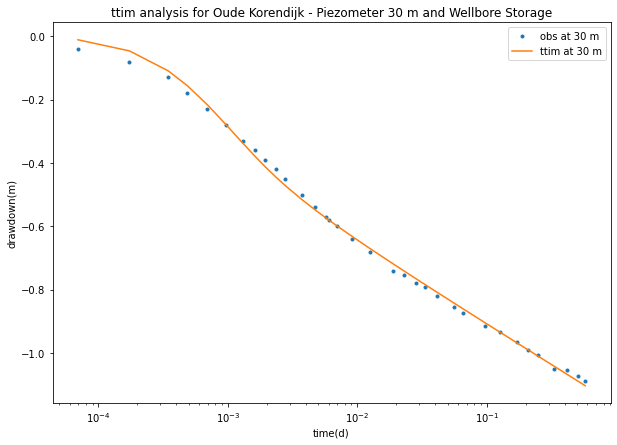

In [68]:
print('rmse:', ca3.rmse())
hm3 = ml1.head(r1, 0, t1)
plt.figure(figsize=(10, 7))
plt.semilogx(t1, h1, '.', label='obs at 30 m')
plt.semilogx(t1, hm3[0], label='ttim at 30 m')
plt.xlabel('time(d)')
plt.ylabel('drawdown(m)')
plt.title('ttim analysis for Oude Korendijk - Piezometer 30 m and Wellbore Storage')
plt.legend();

### Step 6.4. Calibrate using only the data from observation well 2

Here we repeat the step 6.3 for well 2

In [69]:
ca4 = Calibrate(ml1)
ca4.set_parameter(name='kaq0', initial=10)
ca4.set_parameter(name='Saq0', initial=1e-4)
#ca4.set_parameter_by_reference(name='rc', parameter=w1.rc[0:], initial=0.2, pmin=0.01)
ca4.series(name='obs2', x=r2, y=0, t=t2, h=h2, layer=0)
ca4.fit(report=True)
ca4.parameters

.................................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 30
    # data points      = 35
    # variables        = 2
    chi-square         = 0.00976276
    reduced chi-square = 2.9584e-04
    Akaike info crit   = -282.458485
    Bayesian info crit = -279.347789
[[Variables]]
    kaq0:  75.0893629 +/- 1.21674620 (1.62%) (init = 10)
    Saq0:  2.3917e-05 +/- 1.2586e-06 (5.26%) (init = 0.0001)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq0, Saq0) = -0.851


,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0,75.0894,1.216746,1.6204,-inf,inf,10,[75.08936291305277]
Saq0,2.39169e-05,0.000001,5.26246,-inf,inf,0.0001,[2.391691367998678e-05]


rmse: 0.01670137754442732


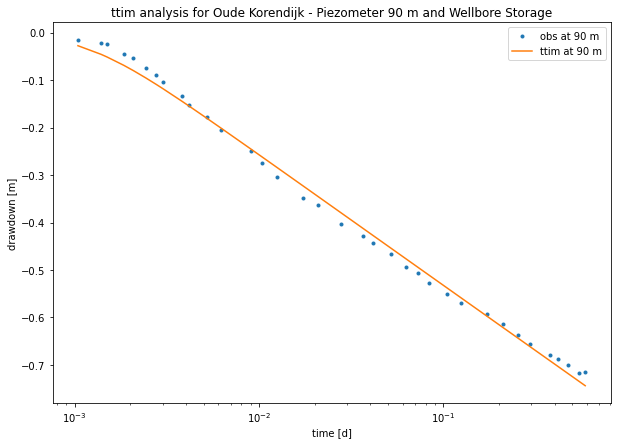

In [70]:
print('rmse:', ca4.rmse())
hm4 = ml1.head(r2, 0, t2)
plt.figure(figsize=(10, 7))
plt.semilogx(t2, h2, '.', label='obs at 90 m')
plt.semilogx(t2, hm4[0], label='ttim at 90 m')
plt.xlabel('time [d]')
plt.ylabel('drawdown [m]')
plt.title('ttim analysis for Oude Korendijk - Piezometer 90 m and Wellbore Storage')
plt.legend();

### Step 6.5. Calibrate model with two datasets simultaneously

Following the same logic from steps 6.3 to 6.4 and the calibration from step 5.3 we can now check the calibration using both wells and including wellbore storage.

In [71]:
ca0 = Calibrate(ml1)
ca0.set_parameter(name='kaq0', initial=10)
ca0.set_parameter(name='Saq0', initial=1e-4)
#ca0.set_parameter_by_reference(name='rc', parameter=w1.rc[0:], initial=0.2, pmin=0.01)
ca0.series(name='obs1', x=r1, y=0, t=t1, h=h1, layer=0)
ca0.series(name='obs2', x=r2, y=0, t=t2, h=h2, layer=0)
ca0.fit(report=True)
ca0.parameters

.........................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 69
    # variables        = 2
    chi-square         = 0.24681339
    reduced chi-square = 0.00368378
    Akaike info crit   = -384.692818
    Bayesian info crit = -380.224605
[[Variables]]
    kaq0:  71.4301741 +/- 2.20521581 (3.09%) (init = 10)
    Saq0:  1.7118e-05 +/- 2.2331e-06 (13.05%) (init = 0.0001)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq0, Saq0) = -0.866


,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0,71.4302,2.205216,3.08723,-inf,inf,10,[71.43017412811331]
Saq0,1.71184e-05,0.000002,13.0452,-inf,inf,0.0001,[1.7118434516330002e-05]


rmse: 0.05980807316640966


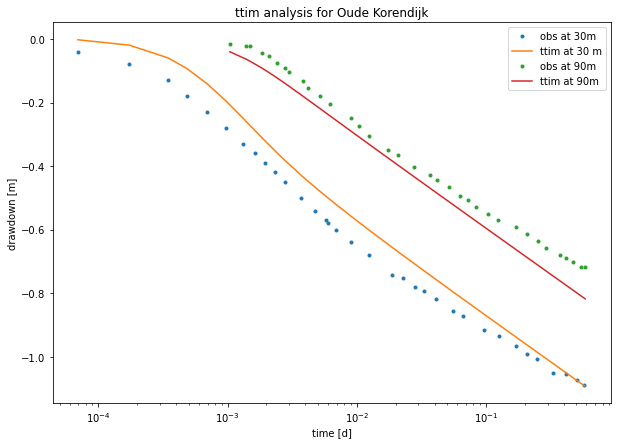

In [72]:
print('rmse:', ca0.rmse())
hs1 = ml1.head(r1, 0, t1)
hs2 = ml1.head(r2, 0 ,t2)
plt.figure(figsize = (10, 7))
plt.semilogx(t1, h1, '.', label='obs at 30m')
plt.semilogx(t1, hs1[0], label='ttim at 30 m')
plt.semilogx(t2, h2, '.', label='obs at 90m')
plt.semilogx(t2, hs2[0], label = 'ttim at 90m')
plt.xlabel('time [d]')
plt.ylabel('drawdown [m]')
plt.title('ttim analysis for Oude Korendijk')
plt.legend();

## Step 7. Comparison of Results

### Step 7.1. Comparison of model performance and Results with and without wellbore storage

#### 7.1.1. RMSE of the two conceptual models

The following table summarises the rmse values of the obtained models with and without well wellbore storage consideration.

In [30]:
t0 = pd.DataFrame(columns=['obs 30 m', 'obs 90 m', 'obs simultaneously'], index=['without rc', 'with rc'])
t0.loc['without rc', 'obs 30 m'] = ca1.rmse()
t0.loc['without rc', 'obs 90 m'] = ca2.rmse()
t0.loc['without rc', 'obs simultaneously'] = ca.rmse()
t0.loc['with rc', 'obs 30 m'] = ca3.rmse()
t0.loc['with rc', 'obs 90 m'] = ca4.rmse()
t0.loc['with rc', 'obs simultaneously'] = ca0.rmse()

t0.style.set_caption('RMSE of two conceptual models')


,obs 30 m,obs 90 m,obs simultaneously
without rc,0.031660,0.022719,0.050060
with rc,0.015273,0.006219,0.050065


Adding wellbore storage improved the fit performance when used drawdown data of the individual observation wells. However, when calibrated the model with both datasets simultaneously, ```rc```  was adjusted to the minimum value. Adding rc did not improve the performance much in this case.

#### 7.1.2. Model comparisons

We can see the summaries of the hydraulic conductivities in the next table.

We will access the parameter values by accessing the ```.parameters``` attribute of each ```Calibrate``` object

Text(0.5, 0, 'Calibration Dataset')

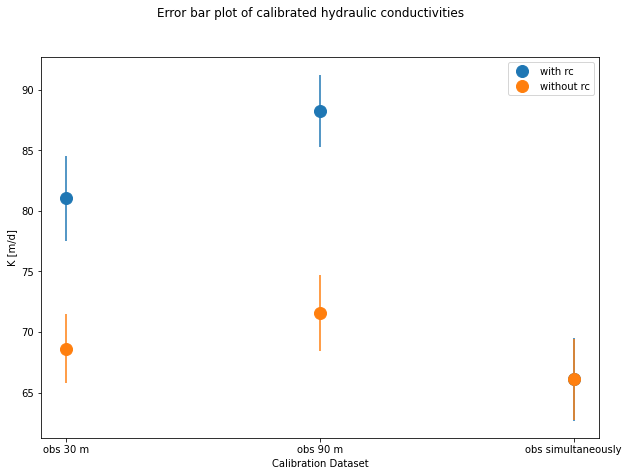

In [31]:
# Preparing the DataFrame:
t1 = pd.DataFrame(columns=['kaq - opt', 'kaq - min', 'kaq - max', 'W. Storage', 'Calib. Dataset']) 
w_storage = ['without rc','without rc','without rc','with rc','with rc','with rc',]
obs_dataset = ['obs 30 m','obs 90 m','obs simultaneously','obs 30 m','obs 90 m','obs simultaneously']

# Looping through all calibration objects and fetching the desired values
for calib,w_sto,obs_dts in zip([ca1,ca2,ca,ca3,ca4,ca0],w_storage,obs_dataset):
    p = calib.parameters #Accessing the parameters Dataframe inside the Calibrate object
    tab = pd.DataFrame([[p.loc['kaq0','optimal'], 2*p.loc['kaq0', 'std'], 2*p.loc['kaq0', 'std'],w_sto,obs_dts]],
                      columns=['kaq - opt', 'kaq - min', 'kaq - max', 'W. Storage', 'Calib. Dataset'])
    t1 = t1.append(tab)

# Plotting
groups = t1.groupby('W. Storage')
plt.figure(figsize = (10,7))
for name, group in groups:
    plt.errorbar(x = group['Calib. Dataset'], y = group['kaq - opt'], yerr = [group['kaq - min'], group['kaq - max']],
                marker='o', linestyle='', markersize=12, label=name)
plt.legend()
plt.suptitle("Error bar plot of calibrated hydraulic conductivities")
plt.ylabel('K [m/d]')
plt.xlabel('Calibration Dataset')

The Errorbar plot shows that the Hydraulic Conductivities calculated are significantly higher with wellbore storage than without when considering the individual wells datasets for calibration.

As for the dataset using both obs wells at the same time, the calibration results have no significant differences.

Both scenarios with and without wellbore storage showed lower values for the calibrated model using both observations, calibration with a single well are overestimated.



### Step 7.2. Compare TTim to results of K&dR, AQTEOLV and MLU:

The final important step is to compare the data obtained from this model with the data from other Aquifer Analysis software. Xinzhu Y. (2020) compared TTim results with the published results in Kruseman and de Ridder (1970), here abbreviated to K&dR, and with the results obtained from the software AQTESOLV (Duffield, 2007) and MLU (Carlson & Randall, 2012).

In [32]:
t = pd.DataFrame(columns=['k [m/d]', 'Ss [1/m]', 'RMSE'], \
                 index=['K&dR', 'TTim', 'AQTESOLV', 'MLU'])
t.loc['TTim'] = np.append(ca.parameters['optimal'].values, ca.rmse())
t.loc['AQTESOLV'] = [66.086, 2.541e-05, 0.05006]
t.loc['MLU'] = [66.850, 2.400e-05, 0.05083]
t.loc['K&dR'] = [55.71429, 1.7E-4, '-']
t.style.set_caption('Comparison of Model Results with different Softwares')

,k [m/d],Ss [1/m],RMSE
K&dR,55.714290,0.000170,-
TTim,66.089357,0.000025,0.050060
AQTESOLV,66.086000,0.000025,0.050060
MLU,66.850000,0.000024,0.050830


Results show good agreement between different analysis programs, including TTim. The values from Kruseman and de Ridder (1970) were obtained through Thiem's approximation, and seems to have been underestimated as the pumping never reached steady-state conditions

## References

* Carlson F, Randall J (2012) MLU: a Windows application for the analysis of aquifer tests and the design of well fields in layered systems. Ground Water 50(4):504–510
* Duffield, G.M., 2007. AQTESOLV for Windows Version 4.5 User's Guide, HydroSOLVE, Inc., Reston, VA.
* Kruseman, G.P., De Ridder, N.A., Verweij, J.M., 1970. Analysis and evaluationof pumping test data. volume 11. International institute for land reclamation and improvement The Netherlands.
* Yang, Xinzhu (2020) Application and comparison of different methodsfor aquifer test analysis using TTim. Master Thesis, Delft University of Technology (TUDelft), Delft, The Netherlands.

#### Next Notebook: 2. reference 